In [3]:
import getpass
import os

from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "RAG Demo 1"
os.environ["USER_AGENT"] = "MyRagDemo/1.0"

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your Langsmith API key: ")

# RAG DEMO 1

Allereerst maken we gebruik van een chat model, in dit geval die van OpenAi.

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Vervolgens moeten we een provider kiezen voor onze embeddings model, ook hier OpenAI.

In [5]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

En een store voor onze vectors. Voor de demo is dit een In Memory store, maar kan ook Elasticsearch zijn o.i.d.

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### Inladen van de documenten
Inladen van een tekst. In dit geval de Silmarillion van Tolkien.
Toch best een lastig boek waar zelfs de meest die-hard fans nog massa's vragen over hebben.

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep the text, skip the rest of the HTML.
bs4_strainer = bs4.SoupStrainer(['pre'])
loader = WebBaseLoader(
    web_paths=("https://archive.org/stream/TheSilmarillionIllustratedJ.R.R.TolkienTedNasmith/The%20Silmarillion%20%28Illustrated%29%20-%20J.%20R.%20R.%20Tolkien%3B%20Ted%20Nasmith%3B_djvu.txt",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
#print(docs[0].page_content[:500])

Total characters: 889084


### Splitsen van de documenten
Ik gebruik hier een algemene splitter. Je hebt specifieke splitters voor code, academische papers, etc.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split text into {len(all_splits)} sub-documents.")

Split text into 1296 sub-documents.


### Opslaan van de chuncks
Omdat we het embeddingsmodel gekoppeld hebben worden de embeddings gegenereerd en als vector opgeslagen.

In [9]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['4f03dd18-00cf-4a73-b360-c0243a62b665', 'f3b1605b-670c-4627-9f27-bbf0fc37aa52', '9ca29e65-db08-4e4d-bace-f90c0a212cfd']


### Aan de slag

In [10]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


### RAG applicatie

We gebruiken een State class om wat zaken bij te houden. In dit geval vraag, context en antwoord.
Twee functies helpen bij de stappen voor het ophalen en het genereren van het antwoord.

In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Grappig: de graph ondersteunt Mermaid Diagrams, dus we kunnen onze simpele flow visualiseren:

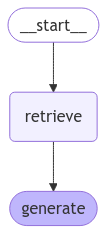

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Uitvoeren

In [13]:
response = graph.invoke({"question": "What is Tolkien's message in the Silmarillion?"})
print(response["answer"])

Tolkien's message in "The Silmarillion" revolves around themes of fallibility, the struggle between good and evil, and the consequences of pride and rebellion. It highlights the tragic consequences of the Exiled Elves' hubris and the enduring conflict against a powerful enemy. Ultimately, it reflects on the nature of beauty, loss, and the hope of redemption within a mythic framework.
